# Chapter 6: Design Justification with Design Structure Matrix

Dear user, we have to justify possible design changes with the complexity of the components involved. \
Given input data from different sources, we will query a LLM to help us output components of the product \
to ultimately construct a comprehensive design structure matrix for further design  justification.

## REQUIREMENTS

For this notebook, you need to have:
- 1 x Pickle file containing Search Terms (from Chap2.ipynb)
- 5 x Text files of Scraped data from Online sources (from Chap2.ipynb)

## TO DO SECTION

In [1]:
'''
Dear user, enter the broad category of your product here! (can be the same as your Search Terms)
'''

product = "Boeing 787 Dreamliner Commercial Plane"

In [2]:
'''
Dear user, enter your directories to the search terms & 5 txt files of Scraped data here!
'''
import pandas as pd
search_terms = pd.read_pickle("support/Scoot 787/searchTerms.pkl")

youtube = f"support/{search_terms}/youtube/comment_list.txt"
reddit = f"support/{search_terms}/reddit/comment_list.txt"
article = f"support/{search_terms}/article/article.txt"
brochure = f"support/{search_terms}/brochure/brochure.txt"
textbook = f"support/{search_terms}/textbook/textbook.txt"

In [3]:
'''
Dear user, please input different input settings to generate the best Design Structure Matrix!
'''
setting_1 = [youtube, reddit]
setting_2 = [article]
setting_3 = [article]
setting_4 = [textbook]
setting_5 = [article, brochure, textbook]
setting_all = [article, brochure, textbook, youtube, reddit]

settings = [setting_1, setting_2, setting_3, setting_4, setting_5, setting_all]
setnames = ['setting_1', 'setting_2', 'setting_3', 'setting_4', 'setting_5', 'setting_all']

## RUN AS INTENDED (DO NOT CHANGE ANYTHING.)

### Set Up

In [4]:
! pip install langchain==0.1.9 chromadb==0.4.24 langchain-openai==0.0.8

DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
""" Set up OpenAI API key """
import os
from dotenv import load_dotenv

load_dotenv()

key = os.getenv("OPENAI_API_KEY")

In [6]:
""" Create DSM folder and subfolders """
import os
import shutil
try:
    os.makedirs("support/%s/%s" % (search_terms, "DSM"))
except FileExistsError:
    shutil.rmtree('support/%s/DSM' % search_terms)
    os.makedirs("support/%s/%s" % (search_terms, "DSM"))

try:
    os.makedirs("support/%s/%s/%s" % (search_terms, "DSM", "components"))
except FileExistsError:
    shutil.rmtree('support/%s/%s/%s' % (search_terms, "DSM", "components"))
    os.makedirs("support/%s/%s/%s" % (search_terms, "DSM", "components"))

try:
    os.makedirs("support/%s/%s/%s" % (search_terms, "DSM", "csv"))
except FileExistsError:
    shutil.rmtree('support/%s/%s/%s' % (search_terms, "DSM", "csv"))
    os.makedirs("support/%s/%s/%s" % (search_terms, "DSM", "csv"))

### Vector Store Helper Functions

In [7]:
""" Initate Vector Store """
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import shutil
import os

def initiate_vector_store(setting):
    """ Combine text files into one """
    with open("combined.txt", "w", encoding="utf-8") as combined_file:
        for file_path in setting:
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
                combined_file.write(content)
    
    """ Load Private Documents of User Manual """
    loader = TextLoader(file_path="combined.txt", encoding='utf-8')
    document = loader.load()
    os.remove('combined.txt')

    """ Split Documents into smaller parts """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=150
    )
    splits = text_splitter.split_documents(document)

    """ Use OpenAI Embeddings """
    embedding = OpenAIEmbeddings()

    """ Remove 'persist' directory, if any """
    try:
        shutil.rmtree('support/%s/persist' % search_terms)       # remove old version
        print("Deleting previous store")
    except:
        print("No store found")

    persist_directory = 'support/%s/persist' % search_terms     # create new version

    """ Apply embeddings on private documents and save in 'persist' directory """
    vectordb = Chroma.from_documents(
        documents=splits,                           # target the splits created from the documents loaded
        embedding=embedding,                        # use the OpenAI embedding specified
        persist_directory=persist_directory         # store in the persist directory for future use
    )

    vectordb.persist()                              # store vectordb

### Private Query for Components Helper Functions

In [8]:
""" Private Query for Components """
import pandas as pd
import pickle
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA

def private_query_components(setname):
    """ Retrieve vectordb created """
    embedding = OpenAIEmbeddings()
    persist_directory = 'support/%s/persist' % search_terms

    vectordb = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding
        )

    print("Processing folder:", search_terms)
    print("Size of Vector Database", vectordb._collection.count())    # same as before
    
    """ Apply language model and vectordb for Chatbot """
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

    qa_chain = RetrievalQA.from_chain_type(
        llm,
        # MMR focuses on balancing relevance and diversity.
        # "k": the total number of documents to retrieve.
        # "fetch_k": number of documents to fetch from the database for each round of selection.
        retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 4, "fetch_k": 6}),      
        return_source_documents=True
        )
    
    """ Ready to use GPT """
    question = f"Identify as many distinct main {product} components that make up a {product}."
    template = " Express the answer only as a Python list with a non-descriptive component (do not add numbering). Do not output anything else. If you don't know the answer, strictly state 'I don't know' instead of making up an answer."

    prompt = question + template
    result = qa_chain({"query": prompt})

    components = result["result"]
    print("Components:", components)

    pickle.dump(components, open("support/%s/DSM/%s/%s.pkl" % (search_terms, "components", setname), "wb"))

### Results for Vector Query for Components

In [9]:
""" Results for Vector Query for Components """
for i in range(len(settings)):
    setting = settings[i]
    setname = setnames[i]
    print(setname)
    initiate_vector_store(setting)
    private_query_components(setname)
    print()

setting_1
Deleting previous store
Processing folder: Scoot 787
Size of Vector Database 511


c:\Users\tanhu\AppData\Local\Programs\Python\Python39\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Components: ['Wings', 'Fuselage', 'Engines', 'Tail', 'Cockpit', 'Landing Gear', 'Windows', 'Doors', 'Interior Cabin', 'Winglets']

setting_2
No store found
Processing folder: Scoot 787
Size of Vector Database 519
Components: ['Wings', 'Fuselage', 'Engines', 'Tail', 'Cockpit', 'Windows', 'Landing Gear']

setting_3
No store found
Processing folder: Scoot 787
Size of Vector Database 527
Components: ['Windows', 'Overhead bins', 'Seats', 'LED lights', 'Aircraft cleanliness']

setting_4
No store found
Processing folder: Scoot 787
Size of Vector Database 1467
Components: ['wing general description', 'centre section', 'outer panels', 'flaps and ailerons', 'other wing features', 'fuselage general description', 'nose section', 'forward fuselage', 'centre fuselage', 'aft fuselage', 'tail section', 'empennage general description', 'horizontal stabiliser and elevator', 'vertical stabiliser and rudder', 'engine installation', 'nacelles and pylons', 'landing gear']

setting_5
No store found
Processin

### Auto DSM from Components Input

In [55]:
""" Create empty CSV matrices for each setting """
import csv
import ast
import pickle

def empty_csv_matrix(components, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write headers
        writer.writerow([''] + components)  # Empty header for the first cell, then components
        
        # Write empty rows with component headers
        for i, component in enumerate(components):
            row = [component] + ['X' if i == j else '' for j in range(len(components))]  # 'X' for diagonal cells, otherwise empty string
            writer.writerow(row)

for i in range(len(setnames)):
    setname = setnames[i]
    with open("support/%s/DSM/components/%s.pkl" % (search_terms, setname), "rb") as f:
        componentstr = pickle.load(f)
        components = ast.literal_eval(componentstr)

    filename = "support/%s/DSM/csv/%s.csv" % (search_terms, setname)

    empty_csv_matrix(components, filename)

In [56]:
""" Helper function for filling up CSV matrixes for each setting """
import csv
import pandas as pd
import pickle
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA

def auto_DSM(components, setname):
    with open("support/%s/DSM/csv/%s.csv" % (search_terms, setname), 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        matrix = list(reader)
    
    for i in range(len(components)):
        element_a = components[i]
        for j in range(len(components)):
            if i == j:
                continue  # Skip diagonal cells
            element_a = components[i]
            element_b = components[j]

            """ Retrieve vectordb created """
            embedding = OpenAIEmbeddings()
            persist_directory = 'support/%s/persist' % search_terms

            vectordb = Chroma(
                persist_directory=persist_directory,
                embedding_function=embedding
                )
            
            """ Apply language model and vectordb for Chatbot """
            llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

            qa_chain = RetrievalQA.from_chain_type(
                llm,
                # The retriever is configured to perform a similarity-based search.
                # - "k": the total number of similar documents to retrieve.
                retriever=vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 4}),     
                return_source_documents=True
                )
            
            """ Ready to use GPT """
            linkage_type = "mechanically"             ### (Adjustable) Specify the linkage type
            
            question = f"Are {element_a} and {element_b} {linkage_type} linked? Strictly state 'Yes' or 'No' or 'Unsure' once."
            template = " Do not output with full stops. Do not output anything else. If you don't know the answer, strictly state 'Unsure' instead of making up an answer or leaving empty."
            
            prompt = question + template

            result = qa_chain({"query": prompt})
            matrix[i+1][j+1] = result["result"]
    
    """ Write the filled matrix back to CSV """
    with open("support/%s/DSM/csv/%s.csv" % (search_terms, setname), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in matrix:
            writer.writerow(row)

In [57]:
""" Results for auto-fill DSM in CSV """
for i in range(len(settings)):
    setting = settings[i]
    setname = setnames[i]
    with open("support/%s/DSM/components/%s.pkl" % (search_terms, setname), "rb") as f:
        componentstr = pickle.load(f)
        components = ast.literal_eval(componentstr)
    print(setname)
    initiate_vector_store(setting)
    auto_DSM(components, setname)
    print("DSM for", setname, "is complete.")

setting_1
No store found
DSM for setting_1 is complete.
setting_2
No store found
DSM for setting_2 is complete.
setting_3
No store found
DSM for setting_3 is complete.
setting_4
No store found
DSM for setting_4 is complete.
setting_5
No store found
DSM for setting_5 is complete.
setting_all
No store found
DSM for setting_all is complete.


In [58]:
""" Helper function for displaying DSM in MatPlotLib """
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

def DSM_display(csv_file, setname):
    df = pd.read_csv(csv_file, index_col=0)

    df.replace({'Yes': 1, 'No': 0, 'X': np.nan, 'Unsure': 2}, inplace=True)

    matrix = df.values
    row_headers = df.index
    col_headers = df.columns

    fig, ax = plt.subplots()
    ax.imshow(matrix, cmap='binary')

    """ Painting the matrix cells """
    for i in range(len(row_headers)):
        for j in range(len(df.columns)):
            if np.isnan(matrix[i, j]):
                color = 'black'
            elif matrix[i, j] == 1:
                color = 'red'
            elif matrix[i, j] == 0:
                color = 'white'
            else:
                color = 'grey'

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color=color)
            ax.add_patch(rect)

    ax.set_xticks(np.arange(len(col_headers)))
    ax.set_yticks(np.arange(len(row_headers)))
    ax.set_xticklabels(list(string.ascii_uppercase)[:len(col_headers)])
    ax.set_yticklabels(row_headers)
    plt.title(f'DSM {setname}')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.savefig("support/%s/DSM/DSM_%s.png" % (search_terms, setname), bbox_inches='tight')
    plt.show()


setting_1


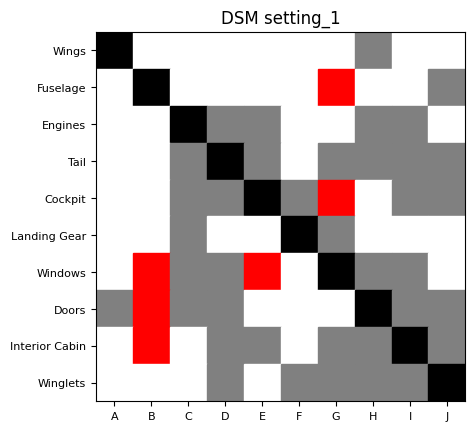

setting_2


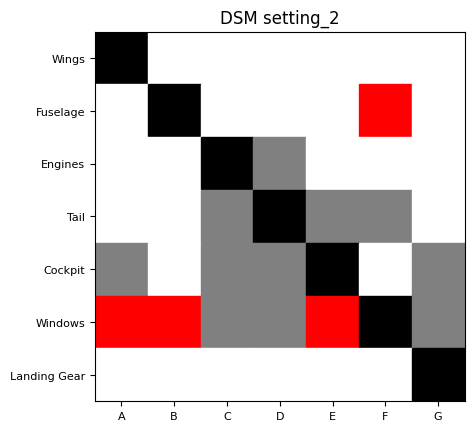

setting_3


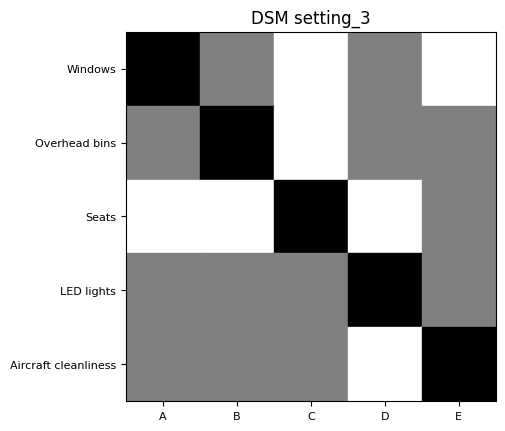

setting_4


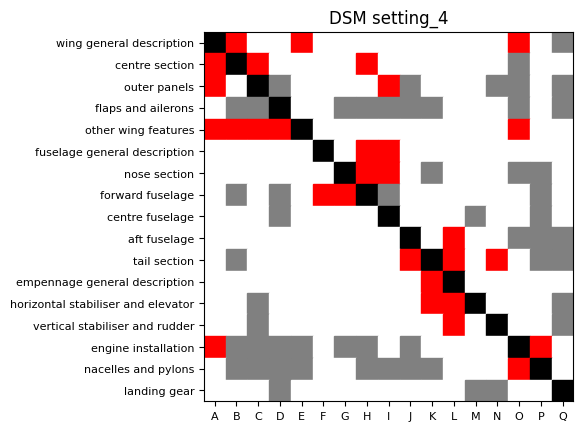

setting_5


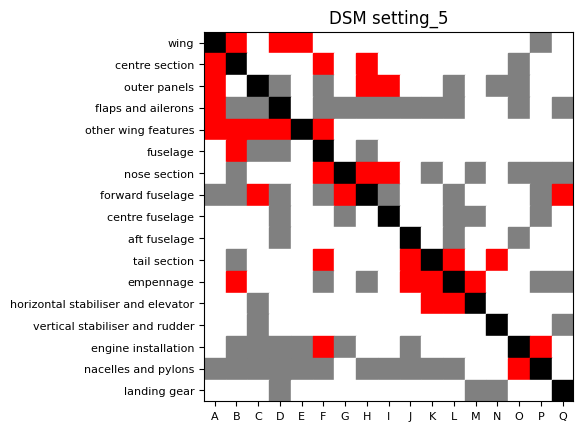

setting_all


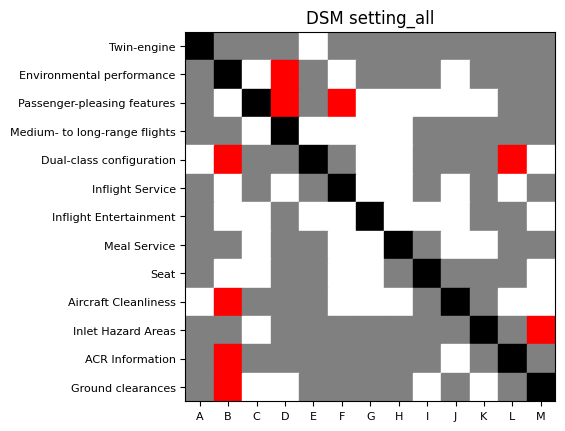

In [59]:
""" Display DSM Results """
for setname in setnames:
    print(setname)
    DSM_display(f'support/{search_terms}/DSM/csv/{setname}.csv', setname)

## TO DO SECTION

### Overall DSM

In [60]:
# (DO NOT EDIT) Helper Function for Overall DSM
import csv
from openai import OpenAI

def auto_DSM_overall(components, setname):
    with open("support/%s/DSM/csv/%s.csv" % (search_terms, setname), 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        matrix = list(reader)
    
    for i in range(len(components)):
        element_a = components[i]
        for j in range(len(components)):
            if i == j:
                continue  # Skip diagonal cells
            element_a = components[i]
            element_b = components[j]

            client = OpenAI()

            linkage_type = "mechanically"             ### (Adjustable) Specify the linkage type
            
            question = f"Are {element_a} and {element_b} {linkage_type} linked? Strictly state 'Yes' or 'No' or 'Unsure' once."
            template = " Do not output with full stops. Do not output anything else. If you don't know the answer, strictly state 'Unsure' instead of making up an answer or leaving empty."
            
            prompt = question + template

            chat_completion = client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt,}],
                temperature=0.5,                                        
            )

            result = chat_completion.choices[0].message.content
            matrix[i+1][j+1] = result
    
    """ Write the filled matrix back to CSV """
    with open("support/%s/DSM/csv/%s.csv" % (search_terms, setname), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in matrix:
            writer.writerow(row)

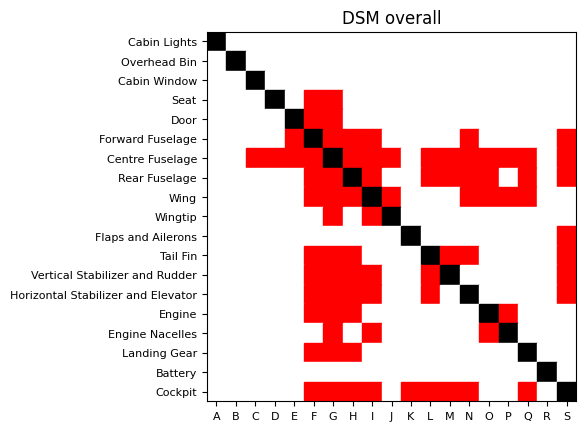

In [63]:
'''
Dear user, analyse the different DSMs and come up with all components that best represent the product.
'''
components = ['Cabin Lights', 'Overhead Bin', 'Cabin Window', 'Seat', 'Door', \
            'Forward Fuselage', 'Centre Fuselage', 'Rear Fuselage', 'Wing', 'Wingtip', \
            'Flaps and Ailerons', 'Tail Fin', 'Vertical Stabilizer and Rudder', 'Horizontal Stabilizer and Elevator', 'Engine', \
            'Engine Nacelles', 'Landing Gear', 'Battery', 'Cockpit']

pickle.dump(components, open("support/%s/DSM/components/overall.pkl" % search_terms, "wb"))
empty_csv_matrix(components, f'support/{search_terms}/DSM/csv/overall.csv')
auto_DSM_overall(components, 'overall')
DSM_display(f'support/{search_terms}/DSM/csv/overall.csv', 'overall')